# 📈 CNN Stock Price Prediction Pipeline

This notebook presents an end-to-end pipeline for forecasting the next day's **end-of-day stock prices** using a Convolutional Neural Network (CNN) model.

The pipeline includes:
- Loading historical stock data
- Enriching it with technical indicators
- Data normalization and windowing
- CNN model training and evaluation
- 📉 Seaborn prediction charts
- 🧠 Feature importance reporting
- 🧾 Styled indicator impact tables
- 💹 Interactive PnL simulation with sliders


In [137]:
# 📦 Imports
import os, random, yaml, logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from data_loader import load_stock_data
from indicators import add_indicators
from preprocessing import normalize_features, df_to_windowed_df, windowed_df_to_date_X_y
from model import build_cnn_model
from evaluation import (
    plot_predictions, compute_metrics, compute_directional_accuracy,
    evaluate_multi_horizon_accuracy, evaluate_directional_accuracy_by_horizon,
    simulate_pnl
)
from feature_analysis import feature_drop_analysis
from evaluation_tables import create_evaluation_tables


In [138]:
# ⚙️ Load config
with open("config/config.yaml", "r") as f:
    config = yaml.safe_load(f)


In [139]:
# 🔧 Set seeds for reproducibility
def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42)


In [140]:
# 📂 Load stock data
tickers = config["tickers"]
dfs = load_stock_data(config["paths"]["csv_folder"], tickers)
df = dfs[0]  # Use the first ticker
df = add_indicators(df)
df.head()


,Close,Open,MACD,MACD_signal,MACD_hist,RSI,BB_upper,BB_lower
Date,,,,,,,,
2020-01-29,104.857788,103.920265,-0.488158,-0.476405,-0.011752,42.817698,106.806403,103.228284
2020-01-30,102.532021,103.938293,-0.636207,-0.508366,-0.127841,42.291947,106.670002,102.922970
2020-01-31,100.638954,102.676254,-0.895964,-0.585885,-0.310079,37.530271,107.221251,101.946231
2020-02-03,100.260338,100.350487,-1.119470,-0.692602,-0.426868,34.110424,107.648103,101.104708
2020-02-04,101.846909,101.017570,-1.155260,-0.785134,-0.370126,42.068965,107.655815,100.774273


In [141]:
# 🔄 Normalize features
df_scaled, scaler_X, scaler_y = normalize_features(df)
feature_cols = [c for c in df_scaled.columns if c != "Close"]
df_scaled.head()


,Open,MACD,MACD_signal,MACD_hist,RSI,BB_upper,BB_lower,Close
Date,,,,,,,,
2020-01-29,0.348786,0.561989,0.537446,0.453427,0.438444,0.243848,0.407432,0.355356
2020-01-30,0.348914,0.553524,0.535413,0.428656,0.432937,0.242760,0.405153,0.338819
2020-01-31,0.339959,0.538672,0.530481,0.389770,0.383060,0.247156,0.397864,0.325358
2020-02-03,0.323457,0.525892,0.523691,0.364849,0.347238,0.250560,0.391585,0.322666
2020-02-04,0.328190,0.523846,0.517804,0.376957,0.430601,0.250622,0.389119,0.333947


In [142]:
# 📈 Convert to windowed format
window_size = config["cnn"]["window_size"]
windowed_df = df_to_windowed_df(df_scaled, window_size)
dates, X, y = windowed_df_to_date_X_y(windowed_df, window_size)


In [143]:
# 🧪 Split data
q_90 = int(len(dates) * 0.90)
q_96 = int(len(dates) * 0.96)

X_train, X_val, X_test = X[:q_90], X[q_90:q_96], X[q_96:]
y_train, y_val, y_test = y[:q_90], y[q_90:q_96], y[q_96:]
dates_train, dates_val, dates_test = dates[:q_90], dates[q_90:q_96], dates[q_96:]


In [144]:
# 🧠 Build & train CNN model
model = build_cnn_model(window_size, X.shape[2])
model.compile(loss="mean_squared_error", optimizer="adam")
model.fit(X_train, y_train, epochs=config["cnn"]["epochs"], batch_size=config["cnn"]["batch_size"], validation_data=(X_val, y_val))


Epoch 1/60


C:\Users\Hossein\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0765 - val_loss: 0.0017
Epoch 2/60
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 3/60
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.1910e-04 - val_loss: 0.0011
Epoch 4/60
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.0618e-04 - val_loss: 0.0012
Epoch 5/60
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.2749e-04 - val_loss: 0.0011
Epoch 6/60
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.7334e-04 - val_loss: 9.9160e-04
Epoch 7/60
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3463e-04 - val_loss: 9.2546e-04
Epoch 8/60
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1729e-04 - val_loss: 8.8650e-04
Epoch 9/60
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9805e-04 - val_loss: 8.6061e-04
Epoch 10/60
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8981e-04 - val_loss: 9.5001e-04
Epoch 11/60
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.6771e-04 - val_loss: 0.0011
Epoch 12/60
71/71 ━━━━━━━━━━━

In [145]:
# 💾 Save model
model_save_path = f"cnn_model_{tickers[0]}.h5"
model.save(model_save_path)


In [146]:
# 📊 Predictions (inverse transform)
train_pred = scaler_y.inverse_transform(model.predict(X_train)).flatten()
val_pred = scaler_y.inverse_transform(model.predict(X_val)).flatten()
test_pred = scaler_y.inverse_transform(model.predict(X_test)).flatten()

y_train_orig = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_val_orig = scaler_y.inverse_transform(y_val.reshape(-1, 1)).flatten()
y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


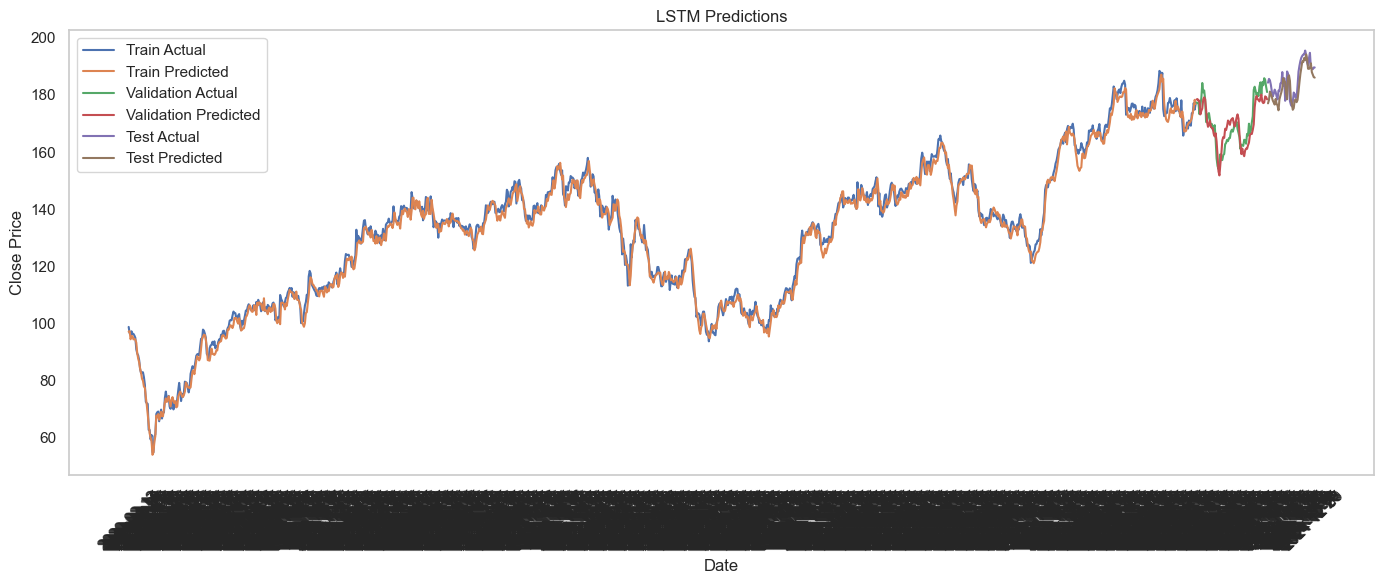

In [147]:
# 📉 Plot predictions
plot_predictions(
    dates_train, y_train_orig, train_pred,
    dates_val, y_val_orig, val_pred,
    dates_test, y_test_orig, test_pred
)


In [148]:
# 📐 Evaluate performance
rmse_test, mae_test = compute_metrics(y_test_orig, test_pred)
dir_acc_test = compute_directional_accuracy(y_test_orig, test_pred)

print(f"Test RMSE: {rmse_test:.4f}")
print(f"Test MAE: {mae_test:.4f}")
print(f"Directional Accuracy: {dir_acc_test:.4f}")


Test RMSE: 4.0071
Test MAE: 3.3830
Directional Accuracy: 0.5102


In [149]:
# 🔁 Multi-horizon evaluation
pd.DataFrame(evaluate_multi_horizon_accuracy(y_test_orig, test_pred))


,Horizon,RMSE,MAE
0,T+1,4.968378,4.096414
1,T+2,5.585956,4.562302
2,T+3,5.811111,4.607816


In [150]:
# 🚥 Directional accuracy by horizon
pd.DataFrame(evaluate_directional_accuracy_by_horizon(y_test_orig, test_pred))


,Horizon,Directional Accuracy
0,T+1,0.428571
1,T+2,0.458333
2,T+3,0.489362


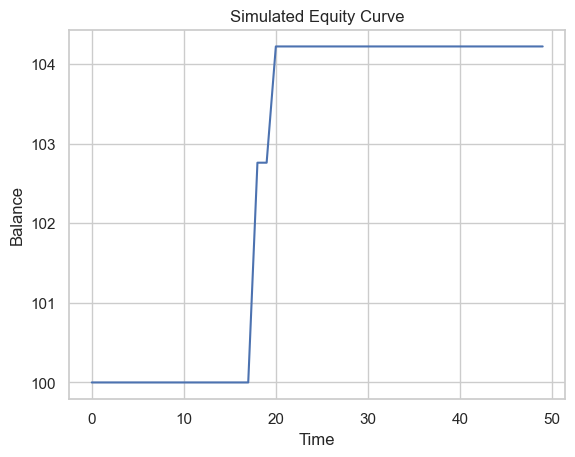

In [151]:
# 💸 PnL Simulation
balance_history, trade_log, final_balance = simulate_pnl(
    y_test_orig, test_pred, initial_balance=100.0,
    threshold=0.005, ticker=tickers[0], output_folder="output"
)

plt.plot(balance_history)
plt.title("Simulated Equity Curve")
plt.xlabel("Time")
plt.ylabel("Balance")
plt.grid(True)
plt.show()


In [152]:
# 🔬 Feature drop analysis
results_df = feature_drop_analysis(
    df_scaled, feature_cols, window_size,
    X, y, scaler_y,
    dates_test, y_test_orig,
    rmse_test, mae_test,
    q_90, q_96,
    config["cnn"]["learning_rate"],
    config["cnn"]["epochs"],
    config["cnn"]["batch_size"]
)

results_df


C:\Users\Hossein\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


C:\Users\Hossein\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


C:\Users\Hossein\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


C:\Users\Hossein\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


C:\Users\Hossein\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


C:\Users\Hossein\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


C:\Users\Hossein\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


,Dropped Feature,RMSE,MAE,RMSE Increase,MAE Increase
5,BB_upper,7.312895,6.678041,3.305789,3.295048
3,MACD_hist,6.078555,5.246800,2.071449,1.863807
1,MACD,4.938445,4.280520,0.931338,0.897527
2,MACD_signal,4.655764,3.882354,0.648658,0.499361
6,BB_lower,4.168399,3.441211,0.161293,0.058218
0,Open,4.098992,3.296970,0.091886,-0.086023
4,RSI,3.500651,2.811770,-0.506455,-0.571223


In [153]:
# 🧾 Evaluation Tables
create_evaluation_tables(
    tickers[0], rmse_test, mae_test, dir_acc_test,
    results_df, output_folder="output"
)



🔎 Summary Metrics Table for SIE:
+--------+---------------------------+--------+
| Ticker |          Metric           | Value  |
+--------+---------------------------+--------+
|  SIE   |         Test RMSE         | 4.0071 |
|  SIE   |         Test MAE          | 3.3830 |
|  SIE   | Test Directional Accuracy | 0.5102 |
+--------+---------------------------+--------+

📊 Feature Drop Analysis Table for SIE:
+--------+-----------------+--------------------+--------------------+---------------------+----------------------+
| Ticker | Dropped Feature |        RMSE        |        MAE         |    RMSE Increase    |     MAE Increase     |
+--------+-----------------+--------------------+--------------------+---------------------+----------------------+
|  SIE   |    BB_upper     | 7.312894892015073  | 6.678041458129883  |  3.305788701206791  |  3.295048236846924   |
|  SIE   |    MACD_hist    | 6.078554898236826  | 5.246800422668457  | 2.0714487074285435  |  1.863807201385498   |
|  SIE   |

In [154]:
# 📊 Signal classification
def classify_signals(y_true, y_pred, threshold=0.005):
    signals = []
    for i in range(len(y_pred) - 1):
        pct_change = (y_pred[i+1] - y_true[i]) / y_true[i]
        if pct_change > threshold:
            signals.append("Buy")
        elif pct_change < -threshold:
            signals.append("Sell")
        else:
            signals.append("Hold")
    from collections import Counter
    return dict(Counter(signals))

classify_signals(y_test_orig, test_pred)


{'Sell': 42, 'Buy': 2, 'Hold': 5}

In [156]:
# 📅 Analyze prediction errors with dates
errors_df = pd.DataFrame({
    "Date": dates_test,
    "Actual Price": y_test_orig,
    "Predicted Price": test_pred,
    "Absolute Error": np.abs(y_test_orig - test_pred)
})

average_error = errors_df["Absolute Error"].mean()
print(f"📉 Average Absolute Error on Test Set: {average_error:.4f}")

# Show top 5 biggest errors
top_errors = errors_df.sort_values(by="Absolute Error", ascending=False).head(5)
print("🔍 Top 5 Prediction Errors:")
display(top_errors)


📉 Average Absolute Error on Test Set: 3.3830
🔍 Top 5 Prediction Errors:


,Date,Actual Price,Predicted Price,Absolute Error
20,2024-11-14,188.199997,178.482361,9.717636
1,2024-10-18,185.600006,178.217804,7.382202
0,2024-10-17,184.279999,177.038849,7.241150
23,2024-11-19,177.839996,184.911179,7.071182
32,2024-12-02,188.119980,181.175079,6.944901


In [157]:
# 📂 Load and compare all summary metric tables
import glob

summary_files = glob.glob("output/summary_metrics_*.csv")
df_list = [pd.read_csv(f) for f in summary_files]
all_metrics_df = pd.concat(df_list)

# 📊 Pivot table for comparison
pivot_df = all_metrics_df.pivot(index="Ticker", columns="Metric", values="Value")
pivot_df = pivot_df.astype(float)
pivot_df.sort_values(by="Test RMSE", inplace=True)

display(pivot_df)


Metric,Test Directional Accuracy,Test MAE,Test RMSE
Ticker,,,
BAS,0.4286,0.7488,0.8965
DTE,0.5918,0.8568,0.9385
SIE,0.5102,3.3830,4.0071
['GOOGL'],0.5510,3.1035,4.1593
SAP,0.5714,3.2625,4.1618
['AMZN'],0.3878,3.6719,4.5081
['NVDA'],0.4694,4.1739,5.0618
VOW3,0.5306,5.6832,6.0356
['BRK-B'],0.4898,4.9847,6.9205


In [158]:
# 🔍 Find models with similar directional accuracy (within ±0.01)
ref_value = pivot_df["Test Directional Accuracy"].mean()
similar_diracc = pivot_df[np.abs(pivot_df["Test Directional Accuracy"] - ref_value) < 0.04]
display(similar_diracc)


Metric,Test Directional Accuracy,Test MAE,Test RMSE
Ticker,,,
SIE,0.5102,3.3830,4.0071
['GOOGL'],0.5510,3.1035,4.1593
VOW3,0.5306,5.6832,6.0356
['BRK-B'],0.4898,4.9847,6.9205
BRK-B,0.4898,4.9847,6.9205


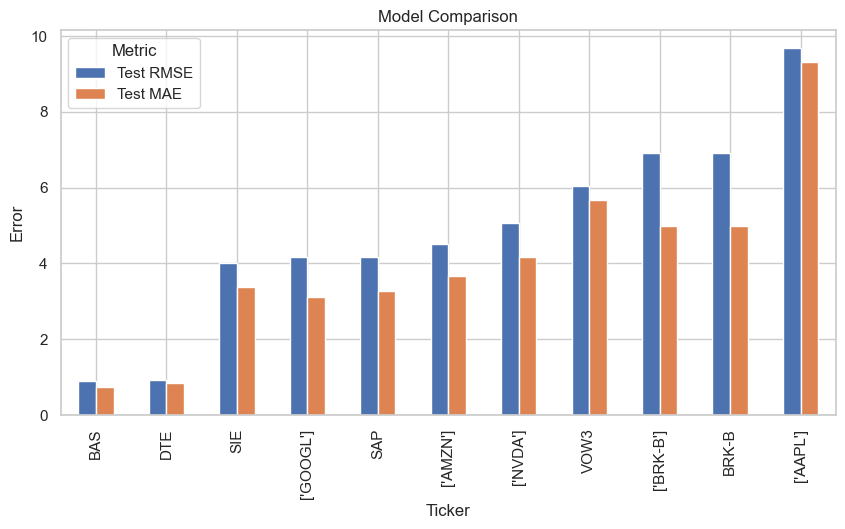

In [159]:
# 📈 Bar plot of RMSE and MAE
pivot_df[["Test RMSE", "Test MAE"]].plot(kind='bar', figsize=(10, 5), title="Model Comparison")
plt.ylabel("Error")
plt.grid(True)
plt.show()


In [160]:
# 📅 Analyze prediction errors with dates
errors_df = pd.DataFrame({
    "Date": dates_test,
    "Actual Price": y_test_orig,
    "Predicted Price": test_pred,
    "Absolute Error": np.abs(y_test_orig - test_pred)
})

average_error = errors_df["Absolute Error"].mean()
print(f"📉 Average Absolute Error on Test Set: {average_error:.4f}")

top_errors = errors_df.sort_values(by="Absolute Error", ascending=False).head(5)
display(top_errors)


📉 Average Absolute Error on Test Set: 3.3830


,Date,Actual Price,Predicted Price,Absolute Error
20,2024-11-14,188.199997,178.482361,9.717636
1,2024-10-18,185.600006,178.217804,7.382202
0,2024-10-17,184.279999,177.038849,7.241150
23,2024-11-19,177.839996,184.911179,7.071182
32,2024-12-02,188.119980,181.175079,6.944901


C:\Users\Hossein\AppData\Local\Temp\ipykernel_28240\713497992.py:16: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Hossein\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


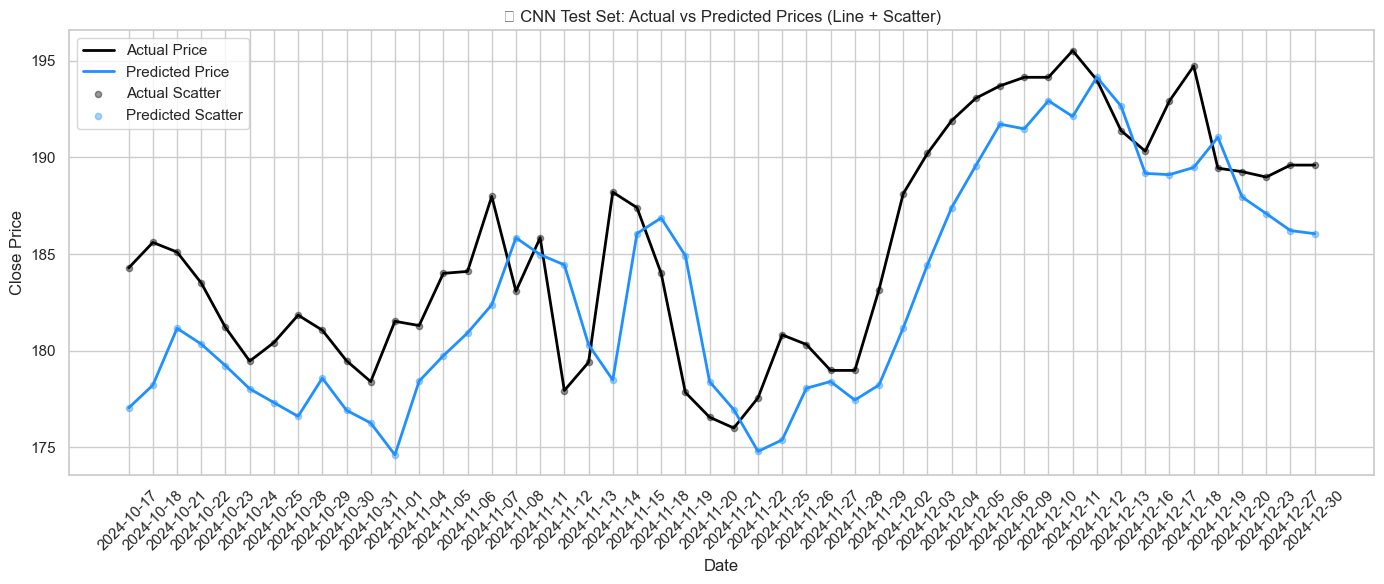

In [161]:
# 📍 Scatter-enhanced plot of actual vs. predicted prices on the test set
plt.figure(figsize=(14, 6))
plt.plot(dates_test, y_test_orig, label='Actual Price', color='black', linewidth=2)
plt.plot(dates_test, test_pred, label='Predicted Price', color='dodgerblue', linewidth=2)

# Add scatter markers
plt.scatter(dates_test, y_test_orig, label='Actual Scatter', color='black', s=20, alpha=0.4)
plt.scatter(dates_test, test_pred, label='Predicted Scatter', color='dodgerblue', s=20, alpha=0.4)

plt.title("🔍 CNN Test Set: Actual vs Predicted Prices (Line + Scatter)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


🎯 Best indicator (smallest RMSE after removal): RSI
🔥 Most important indicator (highest RMSE increase when removed): BB_upper (+3.3058 RMSE)


C:\Users\Hossein\AppData\Local\Temp\ipykernel_28240\601800331.py:19: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Hossein\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


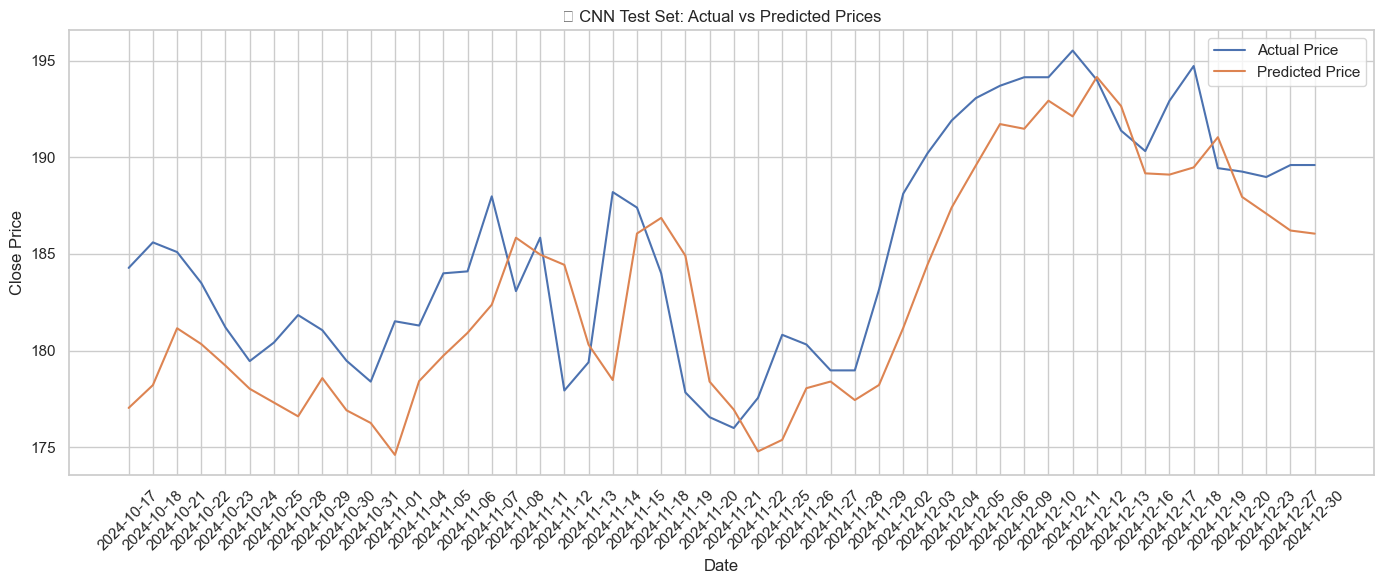

In [162]:
# 🎯 Feature Impact Summary and Chart
least_rmse_feature = results_df.loc[results_df['RMSE'].idxmin()]['Dropped Feature']
most_impactful_feature = results_df.loc[results_df['RMSE Increase'].idxmax()]['Dropped Feature']
impact_value = results_df.loc[results_df['RMSE Increase'].idxmax()]['RMSE Increase']

print(f"🎯 Best indicator (smallest RMSE after removal): {least_rmse_feature}")
print(f"🔥 Most important indicator (highest RMSE increase when removed): {most_impactful_feature} (+{impact_value:.4f} RMSE)")

import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(14,6))
sns.lineplot(x=dates_test, y=y_test_orig, label='Actual Price')
sns.lineplot(x=dates_test, y=test_pred, label='Predicted Price')
plt.xticks(rotation=45)
plt.title("🔍 CNN Test Set: Actual vs Predicted Prices")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()


In [163]:
# 🧾 Styled Feature Table
def style_feature_table(df):
    return df.style\
        .background_gradient(cmap='Reds', subset=['RMSE Increase', 'MAE Increase'])\
        .format({
            'RMSE': '{:.4f}', 'MAE': '{:.4f}',
            'RMSE Increase': '{:+.4f}', 'MAE Increase': '{:+.4f}'
        })\
        .highlight_min(subset=['RMSE', 'MAE'], color='lightgreen')\
        .highlight_max(subset=['RMSE Increase', 'MAE Increase'], color='salmon')

styled_results_df = style_feature_table(results_df)
styled_results_df


,Ticker,Dropped Feature,RMSE,MAE,RMSE Increase,MAE Increase
5,SIE,BB_upper,7.3129,6.6780,+3.3058,+3.2950
3,SIE,MACD_hist,6.0786,5.2468,+2.0714,+1.8638
1,SIE,MACD,4.9384,4.2805,+0.9313,+0.8975
2,SIE,MACD_signal,4.6558,3.8824,+0.6487,+0.4994
6,SIE,BB_lower,4.1684,3.4412,+0.1613,+0.0582
0,SIE,Open,4.0990,3.2970,+0.0919,-0.0860
4,SIE,RSI,3.5007,2.8118,-0.5065,-0.5712


In [164]:
# 💹 Interactive PnL Simulation
import ipywidgets as widgets
from IPython.display import display

def run_simulation(threshold_pct):
    balance = 10000
    margin = 0.01
    position = 0
    entry_price = 0
    equity_curve = []
    trades = []

    for i in range(len(y_test_orig) - 1):
        actual_today = y_test_orig[i]
        predicted_tomorrow = test_pred[i + 1]
        predicted_change = (predicted_tomorrow - actual_today) / actual_today

        action = "HOLD"
        profit = 0

        if predicted_change > threshold_pct and position == 0:
            position = 1
            entry_price = actual_today
            action = "BUY"
        elif predicted_change < -threshold_pct and position == 0:
            position = -1
            entry_price = actual_today
            action = "SELL (SHORT)"
        elif predicted_change < -threshold_pct and position == 1:
            position = 0
            profit = (actual_today - entry_price) * (1 / margin)
            balance += profit
            action = "SELL"
        elif predicted_change > threshold_pct and position == -1:
            position = 0
            profit = (entry_price - actual_today) * (1 / margin)
            balance += profit
            action = "BUY (COVER)"

        equity = balance
        if position == 1:
            equity += (actual_today - entry_price) * (1 / margin)
        elif position == -1:
            equity += (entry_price - actual_today) * (1 / margin)

        equity_curve.append(equity)

        trades.append({
            "Day": dates_test[i],
            "Price": actual_today,
            "Predicted": predicted_tomorrow,
            "Predicted Change %": predicted_change,
            "Action": action,
            "Balance": balance,
            "Equity": equity,
            "Profit": profit if "SELL" in action or "COVER" in action else None
        })

    import matplotlib.pyplot as plt
    import pandas as pd

    df_trades = pd.DataFrame(trades)
    plt.figure(figsize=(14,6))
    plt.plot(dates_test[:-1], equity_curve, label="Equity Curve")
    buy = df_trades[df_trades["Action"].str.contains("BUY")]
    sell = df_trades[df_trades["Action"].str.contains("SELL")]
    plt.scatter(buy["Day"], buy["Price"], color="green", marker="^", label="BUY")
    plt.scatter(sell["Day"], sell["Price"], color="red", marker="v", label="SELL")
    plt.title(f"💹 PnL Simulation (Threshold = {threshold_pct:.4f})")
    plt.xlabel("Date")
    plt.ylabel("Equity / Price")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    print(f"📊 Final Balance: {balance:.2f}")
    print(f"📝 Total Buys: {len(buy)}, Total Sells: {len(sell)}")
    display(df_trades.tail(10))

threshold_slider = widgets.FloatSlider(value=0.005, min=0.0005, max=0.02, step=0.0005, description='Threshold')
ui = widgets.VBox([threshold_slider])
out = widgets.interactive_output(run_simulation, {'threshold_pct': threshold_slider})
display(ui, out)


Output()